# ES413: Assignment 4 [Autoencoders and Variational Autoencoders]

<b>Important: Mount your google drive. [Do this first before running the code]
1. Click on folder icon present on the left side.
2. On the top of the panel, there is folder with google drive logo. Click on it and you have to allow/give file access permission</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font size="3">
<b>Create a pdf report consisting of all the final outputs, and write a short observation for each question. Upload the report to google classroom. You can include colab file link to report itself.</b>
</font>

## Resources

* Introduction to autoencoders: [[Link](https://www.jeremyjordan.me/autoencoders/)]
* An Introduction to Autoencoders: Everything You Need to Know: [[Link](https://www.v7labs.com/blog/autoencoders-guide)]
* Variational autoencoders [[1](https://keras.io/examples/generative/vae/)][[2](https://theaisummer.com/latent-variable-models/)][[3](https://theaisummer.com/Autoencoder/)][[4](https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/)]
* Tensorflow [[1](https://www.tensorflow.org/tutorials/customization/custom_layers)]
* TSNE [[1](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)][[2](https://www.youtube.com/watch?v=MnRskV3NY1k&ab_channel=T%C3%BCbingenMachineLearning)][[3](https://www.youtube.com/watch?v=xLwEo_lGVrk&ab_channel=RANJIRAJ)]
* Notes [[1](https://drive.google.com/file/d/1NgGYjK5JRwb9pszFLsomPyiYtBSInFK1/view?usp=sharing)][[2](https://drive.google.com/file/d/1SZmYf8mHopZ2NWGqVhknQvER-bHs5ysj/view?usp=sharing)][[3](https://drive.google.com/file/d/1c_HlG2ye_LXU6i6oal8XEOGFkn4VcP7s/view?usp=sharing)][[4](https://drive.google.com/file/d/1p3DqZZ25E3tlQ6z-OCc-Rz-oQ-Hm_pkw/view?usp=sharing)][[5](https://drive.google.com/file/d/12HDpsFSD87DqQs8JnhuLbDhZMZXZhOPW/view?usp=sharing)]

## Importing all the libraries

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, models
from sklearn.model_selection import train_test_split
tf.random.set_seed(45)
from keras import metrics
%matplotlib inline

import os

ckpt_dir = './drive/MyDrive/Extra/DeepLearning/ckpt/'

if not os.path.isdir(ckpt_dir):
    os.makedirs(ckpt_dir)

## Utils

In [2]:
class Metrics:
    def __init__(self):
        pass
    
    def precision(self, y, y_hat, cls):
        '''
            y    : n-dim numpy array
            y_hat: n-dim numpy array
            cls  : class
        '''
        if np.sum(y_hat==cls)>0:
            return np.sum(y[y_hat==cls]==cls)/np.sum(y_hat==cls)
        else:
            return 0.0

    def recall(self, y, y_hat, cls):
        '''
            y    : n-dim numpy array
            y_hat: n-dim numpy array
            cls  : class
        '''
        if np.sum(y==cls)>0:
            return np.sum(y_hat[y==cls]==cls)/np.sum(y==cls)
        else:
            return 0.0

    def acc(self, y, y_hat):
        '''
            y    : n-dim numpy array
            y_hat: n-dim numpy array
        '''
        return np.sum(y==y_hat)/y.shape[0]

In [3]:
def vis_output(X):
    X = X.numpy()
    N      = X.shape[0]
    img_h  = X.shape[1]
    img_w  = X.shape[2]
    img_c  = X.shape[3]
    C      = 8
    R      = N // C + 1
    h, w   = 0, 0
    canvas = np.ones((R*img_h, C*img_w, img_c), dtype=np.uint8)

    for img in X:
        img = np.uint8(np.clip(255*(img * 0.5 + 0.5), 0.0, 255.0))
        canvas[h:h+img_h, w:w+img_w, :] = img
        w += img_w
        if w>=(C*img_w):
            w  = 0
            h += img_h

    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    return canvas

In [4]:
def plt_data(x_real, x_recon):
    x_real  = vis_output(x_real)
    x_recon = vis_output(x_recon)
    plt.imshow(x_real)
    plt.title('Real')
    plt.axis('off')
    plt.show()
    plt.clf()
    plt.imshow(x_recon)
    plt.title('Reconstructed')
    plt.axis('off')
    plt.show()
    plt.clf()

## Dataset

In [5]:
def get_batch(X, Y, batch_size=64):
    return tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(batch_size).batch(batch_size=batch_size, drop_remainder=False)

##### Loading cifar10 dataset from keras

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[:3000]
Y_train = Y_train[:3000]
X_test  = X_test[:300]
Y_test  = Y_test[:300]

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test  = tf.convert_to_tensor(Y_test)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3000, 32, 32, 3) (3000, 1) (300, 32, 32, 3) (300, 1)


###### Normalizing the dataset

In [ ]:
X_train = (X_train - 127.5) / 127.5 # Normalizing data into range: -1 to 1
X_test  = (X_test  - 127.5) / 127.5 # Normalizing data into range: -1 to 1

In [ ]:
batch_size  = 256
train_batch = get_batch(X_train, Y_train, batch_size)
test_batch  = get_batch(X_test, Y_test, batch_size)
x, y = next(iter(train_batch))
print(x.shape, y.shape)

(256, 32, 32, 3) (256, 1)


## Autoencoder [7.5 Marks]

<font size="3">
Given a code for autoencoder, you have to write the missing part i.e complete the code for decoder. Hints are present within the code itself and also you can refer to the links given in the reference.
</font>
<br/><br/>
<font size="3">
Visualized the embedding learn through encoder-decoder network using TSNE method (prefer n_components=2).
</font>

#### Network

<img src='https://www.linkpicture.com/q/Autoencoder_1.png' type='image'>

In [ ]:
def conv_block(filters, kernel_size, strides, padding='same', alpha=0.02, drop_rate=0.1):
    return models.Sequential([
                       layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding),
                       layers.BatchNormalization(),
                       layers.Activation('leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])

def transpose_conv_block(filters, kernel_size, strides, padding='same', alpha=0.02, drop_rate=0.1):
    # write your code here, you have to use  Conv2DTranspose
    return models.Sequential([
                       layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding),
                       layers.BatchNormalization(),
                       layers.Activation('leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])

class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        enc_filters     = [32, 64, 128, 256]
        enc_kernel_size = [ 3,  3,   3,   3]
        enc_strides     = [ 2,  2,   2,   4]
        self.enc_depth = len(enc_filters)

        self.enc_start_conv = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='leaky_relu')

        self.enc_block = [conv_block(enc_filters[layer_no], \
                                     enc_kernel_size[layer_no], \
                                     enc_strides[layer_no], \
                                     padding='same', alpha=0.02, drop_rate=0.1) \
                          for layer_no in range(self.enc_depth)]

        # Write the decoder here
        dec_filters     = [256, 128, 64, 32]
        dec_kernel_size = [ 3,  3,   3,   3]
        dec_strides     = [ 4,  2,   2,   2]
        self.dec_depth = len(dec_filters)

        

        self.dec_block = [transpose_conv_block(dec_filters[layer_no], \
                                     dec_kernel_size[layer_no], \
                                     dec_strides[layer_no], \
                                     padding='same', alpha=0.02, drop_rate=0.1) \
                          for layer_no in range(self.dec_depth)]

        self.dec_end_conv = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='tanh')

    def call(self, x):
        
        x = self.enc_start_conv( x ) 
        # storing output in same variable can save gpu memory
        # But while doing this we have to be careful
        # print(x.shape)
        for layer_no in range(self.enc_depth):
            x = self.enc_block[layer_no]( x )
            # print(x.shape)
        
        x_embd = tf.squeeze(tf.squeeze(x, axis=1), axis=1) # batch, 1, 1, 256 -> batch, 256

        
        # Write your code here, for decoder function

        for layer_no in range(self.dec_depth):
            x = self.dec_block[layer_no]( x )
            
        x = self.dec_end_conv( x ) 
        
        
        return x, x_embd

# Testing
X_sample      = tf.random.normal(shape=(1, 32, 32, 3))
testing_model = Autoencoder()
X_sample_out, X_sample_out_embd  = testing_model(X_sample)
print(X_sample.shape, X_sample_out.shape, X_sample_out_embd.shape)

(1, 32, 32, 3) (1, 32, 32, 3) (1, 256)


In [ ]:
def train_step(model, opt, X):
    
    with tf.GradientTape() as tape:
        noise = tf.random.normal(shape=X.shape, mean=0.0, stddev=0.1)
        X_noisy  = X + noise
        X_hat, _ = model(X_noisy, training=True)
        loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    opt.apply_gradients(zip(gradients, variables))
    return loss

In [ ]:
def test_step(model, X):
    # Write your code here
    X_hat, _ = model(X, training=False)
    loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)
    return loss

#### Main

##### Model parameters

###### Hyperparameters

In [ ]:
lr = 3e-4

In [ ]:
# !rm -rf ckpt_dir+'auto_ckpt'   # Uncomment this to delete checkpoint file

In [ ]:
model = Autoencoder()
opt   = tf.keras.optimizers.Adam(learning_rate=lr)
ckpt  = tf.train.Checkpoint(step=tf.Variable(1), model=model, opt=opt)
ckpt_man = tf.train.CheckpointManager(ckpt, directory=ckpt_dir+'auto_ckpt', max_to_keep=20)
ckpt.restore(ckpt_man.latest_checkpoint).expect_partial()
if ckpt_man.latest_checkpoint:
    print('Restored from the latest checkpoint: {}'.format(ckpt.step))

In [ ]:
EPOCHS         = 100
START          = int(ckpt.step)

##### Training network

In [ ]:
for epoch in range(START, EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    test_loss  = tf.keras.metrics.Mean()
    tq         = tqdm(train_batch)

    for itr, (x, y) in enumerate(tq, start=1):
        loss = train_step(model, opt, x)
        train_loss.update_state(loss)
        tq.set_description('Epoch: {} Train Loss: {:0.3f}'.format(epoch, train_loss.result()))
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _ = model(x, training=False)
    plt_data(x, x_out)

    tq = tqdm(test_batch)
    for itr, (x, y) in enumerate(tq, start=1):
        loss = test_step(model, x)
        test_loss.update_state(loss)
        tq.set_description('Epoch: {} Test Loss: {:0.3f}'.format(epoch, test_loss.result()))
    
    ckpt.step.assign_add(1)
    ckpt_man.save()
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _ = model(x, training=False)
    plt_data(x, x_out)
    

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


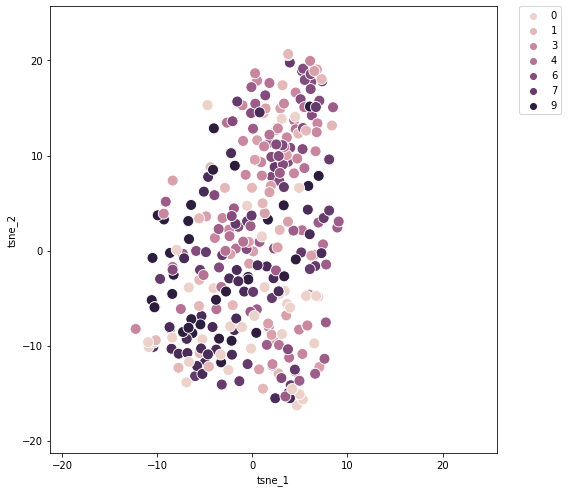

In [ ]:

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
X_out, X_embd_Out = model(X_test, training = False)
import numpy as np
X = []

for x in X_out:
    temp = list(np.array(x).flatten())
    X.append(temp)
    
    
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=45, perplexity=25, n_iter=5000, learning_rate=10)
tsne_result = tsne.fit_transform(X)
tsne_result.shape
# (300, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y_test.numpy().flatten()})
fig, ax = plt.subplots(1,figsize = (8,14))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)



## Variational Autoencoder [7.5 Marks]

<font size="3">
Given a code for variational autoencoder, you have to write the missing part i.e complete the code for decoder. Hints are present within the code itself and also you can refer to the links given in the reference.
</font>
<br/><br/>
<font size="3">
Visualized the embedding learn through encoder-decoder network using TSNE method (prefer n_components=2).
</font>
<br/><br/>
<font size="3">
Train VAE network on MNIST dataset and use the same number of dataset size i.e 3000 for train and 300 for test. Also visualize the embedding using TSNE method (prefer n_components=2).
</font>

In [ ]:
def conv_block(filters, kernel_size, strides, padding='same', drop_rate=0.1):
    return models.Sequential([
                       layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])

def transpose_conv_block(filters, kernel_size, strides, padding='same', drop_rate=0.1):
    return models.Sequential([
                       layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])
    
    

class Variational_Autoencoder(Model):
    def __init__(self):
        super(Variational_Autoencoder, self).__init__()
        enc_filters     = [32, 64, 256]
        enc_kernel_size = [ 3,  3,   3]
        enc_strides     = [ 2,  2,   2]
        self.enc_depth = len(enc_filters)

        self.enc_start_conv = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='leaky_relu')

        self.enc_block = [conv_block(enc_filters[layer_no], \
                                     enc_kernel_size[layer_no], \
                                     enc_strides[layer_no], \
                                     padding='same', drop_rate=0.1) \
                          for layer_no in range(self.enc_depth)]
        
        self.flat       = layers.Flatten()
        self.enc_hidden = layers.Dense(units=256, activation='leaky_relu')

        # We are assumoing distribution to be Gaussian, so two variables in it MU and STD or VAR
        self.dense_mu   = layers.Dense(units=128) # MU
        self.dense_var  = layers.Dense(units=128) # VAR


        dec_filters     = [ 256, 64, 32]
        dec_kernel_size = [   3,  3,  3]
        dec_strides     = [   2,  2,  2]
        self.dec_depth = len(dec_filters)

        self.dec_hidden  = layers.Dense(units=256, activation='leaky_relu')
        self.dec_dense   = layers.Dense(units=4096, activation='leaky_relu')
        self.dec_reshape = layers.Reshape(target_shape=[4, 4, 256])
        
        # Write your code here to create decoder block

        
        self.dec_block = [transpose_conv_block(dec_filters[layer_no], \
                                     dec_kernel_size[layer_no], \
                                     dec_strides[layer_no], \
                                     padding='same', drop_rate=0.1) \
                          for layer_no in range(self.dec_depth)]

        self.dec_end_conv = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='tanh')

    def call(self, x):
        
        x = self.enc_start_conv( x ) 
        # storing output in same variable can save gpu memory
        # But while doing this we have to be careful
        # print(x.shape)
        for layer_no in range(self.enc_depth):
            x = self.enc_block[layer_no]( x )
            # print(x.shape)
        
        x       = self.enc_hidden( self.flat( x ) )
        x_mu    = self.dense_mu( x )
        x_var   = self.dense_var( x )
        
        epsilon = tf.random.normal(shape=x_mu.shape, mean=0.0, stddev=1.0)
        z = tf.add(x_mu, tf.exp(x_var) * epsilon)
        
        z = self.dec_reshape( self.dec_dense( self.dec_hidden( z ) ) )

        # Write your code here for decoder loop
        for layer_no in range(self.dec_depth):
            z = self.dec_block[layer_no]( z )
        
        x = self.dec_end_conv( z )
        # print(x.shape)
        return x, x_mu, x_var

# Testing
X_sample      = tf.random.normal(shape=(1, 32, 32, 3))
testing_model = Variational_Autoencoder()
X_sample_out, X_sample_out_embd, _  = testing_model(X_sample)
print(X_sample.shape, X_sample_out.shape, X_sample_out_embd.shape)

(1, 32, 32, 3) (1, 32, 32, 3) (1, 128)


In [ ]:
def train_step_vae(model, opt, X, batch_size):
    
    with tf.GradientTape() as tape:
        X_hat, x_mu, x_var = model(X, training=True)
        kl_loss = - 0.5 * tf.reduce_mean(1 + x_var - tf.square(x_mu) - tf.exp(x_var), axis=-1)
        pixel_loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)
        loss        = tf.reduce_mean(pixel_loss + kl_loss)

    # Write gradient computation part here
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    opt.apply_gradients(zip(gradients, variables))
    return loss

In [ ]:
def test_step_vae(model, X, batch_size):
    X_hat, _, __ = model(X, training=False)
    loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)
    
    return loss

In [ ]:
!rm -rf ckpt_dir+'var_auto_ckpt'

In [ ]:
lr = 3e-4
model = Variational_Autoencoder()
opt   = tf.keras.optimizers.Adam(learning_rate=lr)
ckpt  = tf.train.Checkpoint(step=tf.Variable(1), model=model, opt=opt)
ckpt_man = tf.train.CheckpointManager(ckpt, directory=ckpt_dir+'var_auto_ckpt', max_to_keep=20)
ckpt.restore(ckpt_man.latest_checkpoint).expect_partial()
if ckpt_man.latest_checkpoint:
    print('Restored from the latest checkpoint: {}'.format(ckpt.step))

In [ ]:
EPOCHS         = 200
START          = int(ckpt.step)

In [ ]:
for epoch in range(START, EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    test_loss  = tf.keras.metrics.Mean()
    tq         = tqdm(train_batch)

    for itr, (x, y) in enumerate(tq, start=1):
        loss = train_step_vae(model, opt, x, batch_size)
        train_loss.update_state(loss)
        tq.set_description('Epoch: {} Train Loss: {:0.3f}'.format(epoch, train_loss.result()))
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _, _ = model(x, training=False)
    plt_data(x, x_out)

    tq = tqdm(test_batch)
    for itr, (x, y) in enumerate(tq, start=1):
        loss = test_step_vae(model, x, batch_size)
        test_loss.update_state(loss)
        tq.set_description('Epoch: {} Test Loss: {:0.3f}'.format(epoch, test_loss.result()))
    
    ckpt.step.assign_add(1)
    ckpt_man.save()
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _, _ = model(x, training=False)
    plt_data(x, x_out)

Output hidden; open in https://colab.research.google.com to view.

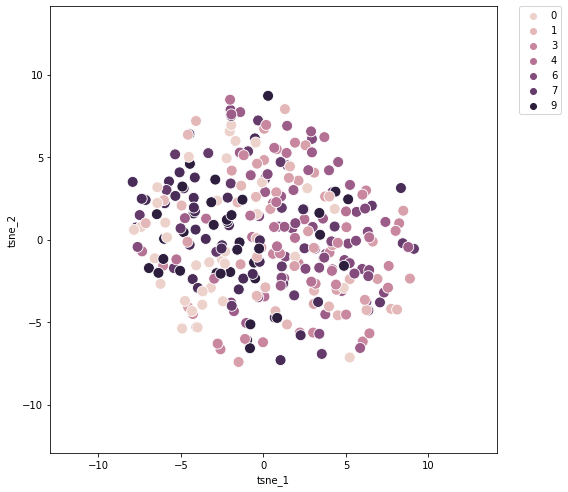

In [ ]:
 from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
X_out, X_embd_Out, __ = model(X_test, training = False)
import numpy as np
X = []

for x in X_out:
    temp = list(np.array(x).flatten())
    X.append(temp)
   
expe = []
i = int(0)

for j in np.arange(300):
    
    
    temp = np.concatenate((X_embd_Out.numpy()[i], __.numpy()[i]),axis=0)
    expe.append(temp)
    
    i += 1
    
    
    
experiment = np.array([X_embd_Out.numpy(), __.numpy()]).reshape(300,-1)
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=45, perplexity=50, n_iter=5000, learning_rate=10,init='random')
tsne_result = tsne.fit_transform(X_embd_Out)
tsne_result.shape
# (300, 2)
# Two dimensions for each of our images
 
palette = ["blue","red","green","yellow","black","purple","orange","brown","pink", "grey"]    
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y_test.numpy().flatten()})
fig, ax = plt.subplots(1,figsize = (8,14))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


MNIST DATASET:


In [6]:
def get_batch(X, Y, batch_size=64):
    return tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(batch_size).batch(batch_size=batch_size, drop_remainder=False)

In [7]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[:3000]
Y_train = Y_train[:3000]
X_test  = X_test[:300]
Y_test  = Y_test[:300]

print(X_train.shape) 

11501568/11490434 [==============================] - 0s 0us/step
(3000, 28, 28)


In [8]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [9]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test  = tf.convert_to_tensor(Y_test)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3000, 28, 28, 1) (3000,) (300, 28, 28, 1) (300,)


In [10]:
batch_size  = 256
train_batch = get_batch(X_train, Y_train, batch_size)
test_batch  = get_batch(X_test, Y_test, batch_size)
x, y = next(iter(train_batch))
print(x.shape, y.shape)


(256, 28, 28, 1) (256,)


In [11]:
def conv_block(filters, kernel_size, strides, padding='same', drop_rate=0.1):
    return models.Sequential([
                       layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])

def transpose_conv_block(filters, kernel_size, strides, padding='same', drop_rate=0.1):
    return models.Sequential([
                       layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='leaky_relu'),
                       layers.Dropout(rate=drop_rate)
                       ])
    

class Variational_Autoencoder(Model):
    def __init__(self):
        super(Variational_Autoencoder, self).__init__()
        enc_filters     = [64, 256]
        enc_kernel_size = [3,   3]
        enc_strides     = [2,   2]
        self.enc_depth = len(enc_filters)

        self.enc_start_conv = layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='leaky_relu')

        self.enc_block = [conv_block(enc_filters[layer_no], \
                                     enc_kernel_size[layer_no], \
                                     enc_strides[layer_no], \
                                     padding='same', drop_rate=0.1) \
                          for layer_no in range(self.enc_depth)]
        
        self.flat       = layers.Flatten()
        self.enc_hidden = layers.Dense(units=224, activation='leaky_relu')

        # We are assumoing distribution to be Gaussian, so two variables in it MU and STD or VAR
        self.dense_mu   = layers.Dense(units=112) # MU
        self.dense_var  = layers.Dense(units=112) # VAR


        dec_filters     = [64, 32]
        dec_kernel_size = [3,  3]
        dec_strides     = [2,  2]
        self.dec_depth = len(dec_filters)

        self.dec_hidden  = layers.Dense(units=224, activation='leaky_relu')
        self.dec_dense   = layers.Dense(units=7*7*32, activation='leaky_relu')
        self.dec_reshape = layers.Reshape(target_shape=[7, 7, 32])
        
        # Write your code here to create decoder block
        
        self.dec_block = [transpose_conv_block(dec_filters[layer_no], \
                                     dec_kernel_size[layer_no], \
                                     dec_strides[layer_no], \
                                     padding='same', drop_rate=0.1) \
                          for layer_no in range(self.dec_depth)]
        #end of my code

        self.dec_end_conv = layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='tanh')

    def call(self, x):
        
        x = self.enc_start_conv( x ) 
        # storing output in same variable can save gpu memory
        # But while doing this we have to be careful
        # print(x.shape)
        for layer_no in range(self.enc_depth):
            x = self.enc_block[layer_no]( x )
            # print(x.shape)
        
        x       = self.enc_hidden( self.flat( x ) )
        x_mu    = self.dense_mu( x )
        x_var   = self.dense_var( x )
        
        epsilon = tf.random.normal(shape=x_mu.shape, mean=0.0, stddev=1.0)
        z = tf.add(x_mu, tf.exp(x_var) * epsilon)
        
        z = self.dec_reshape( self.dec_dense( self.dec_hidden( z ) ) )

        # Write your code here for decoder loop
        
        for layer_no in range(self.dec_depth):
            z = self.dec_block[layer_no]( z )
            
        #end of my code
        
        x = self.dec_end_conv( z )
        # print(x.shape)
        return x, x_mu, x_var

# Testing
X_sample      = tf.random.normal(shape=(1, 28, 28,1))
testing_model = Variational_Autoencoder()
X_sample_out, X_sample_out_embd, _  = testing_model(X_sample)
print(X_sample.shape, X_sample_out.shape, X_sample_out_embd.shape)

(1, 28, 28, 1) (1, 28, 28, 1) (1, 112)


In [12]:
def train_step_vae(model, opt, X, batch_size):
    #plt_data(X[:5], X[:5])
    #print(np.shape(X))
    with tf.GradientTape() as tape:
        X_hat, x_mu, x_var = model(X, training=True)
        
        
        kl_loss = - 0.5 * tf.reduce_mean(1 + x_var - tf.square(x_mu) - tf.exp(x_var), axis=-1)
        #pixel_loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)
        pixel_loss = tf.reduce_mean(metrics.binary_crossentropy(X, X_hat))
        
        loss        = tf.reduce_mean(pixel_loss+kl_loss)
        
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        opt.apply_gradients(zip(gradients, variables))

    # Write gradient computation part here
    
    
    #end of my code
    
    
    return loss

In [13]:
def test_step_vae(model, X, batch_size):
    # Write your code here
    
    X_hat, x_mu, x_var = model(X, training=True)
    kl_loss = - 0.5 * tf.reduce_mean(1 + x_var - tf.square(x_mu) - tf.exp(x_var), axis=-1)
    #pixel_loss  = tf.keras.losses.MeanAbsoluteError()(X, X_hat)
    pixel_loss = tf.reduce_mean(metrics.binary_crossentropy(X, X_hat))
    
    loss        = tf.reduce_mean(pixel_loss + kl_loss)
    #end of my code
    
    return loss

In [14]:
#!rm -rf ckpt_dir+'var_auto_ckpt'

#deleted manually, I have windows not linux

In [15]:
lr = 8E-4
model1 = Variational_Autoencoder()
opt   = tf.keras.optimizers.Adam(learning_rate=lr)
ckpt  = tf.train.Checkpoint(step=tf.Variable(1), model=model1, opt=opt)
ckpt_man = tf.train.CheckpointManager(ckpt, directory=ckpt_dir+'var_auto_ckpt', max_to_keep=20)
ckpt.restore(ckpt_man.latest_checkpoint).expect_partial()
if ckpt_man.latest_checkpoint:
    print('Restored from the latest checkpoint: {}'.format(ckpt.step))

In [16]:
EPOCHS         = 200
START          = int(ckpt.step)

In [17]:
for epoch in range(0,EPOCHS):
    train_loss = tf.keras.metrics.Mean()
    test_loss  = tf.keras.metrics.Mean()
    tq         = tqdm(train_batch)

    for itr, (x, y) in enumerate(tq, start=1):
        loss = train_step_vae(model1, opt, x, batch_size)
        train_loss.update_state(loss)
        tq.set_description('Epoch: {} Train Loss: {:0.3f}'.format(epoch, train_loss.result()))
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _, _ = model1(x, training=False)
    plt_data(x, x_out)

    tq = tqdm(test_batch)
    for itr, (x, y) in enumerate(tq, start=1):
        loss = test_step_vae(model1, x, batch_size)
        test_loss.update_state(loss)
        tq.set_description('Epoch: {} Test Loss: {:0.3f}'.format(epoch, test_loss.result()))
    
    ckpt.step.assign_add(1)
    ckpt_man.save()
    
    x     = x[:16] # selecting first 16 examples to plot
    x_out, _, _ = model1(x, training=False)
    plt_data(x, x_out)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


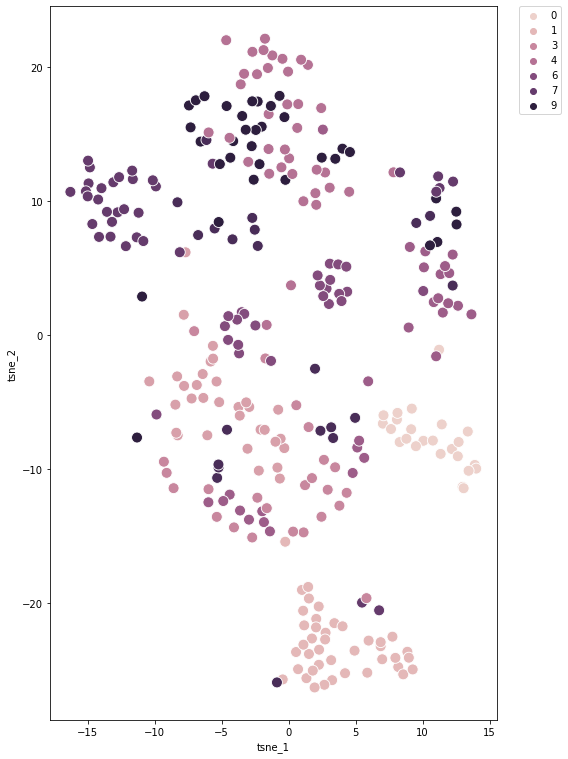

In [18]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
X_out, X_embd_Out, _ = model1(X_test, training = False)

    
    
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=45, perplexity=25, n_iter=5000, learning_rate=10)
tsne_result = tsne.fit_transform(X_embd_Out)
tsne_result.shape
# (300, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y_test.numpy().flatten()})
fig, ax = plt.subplots(1,figsize = (8,14))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)